### A test of nibabel to load nii DCE-MRI data into dataset

In [17]:
# Select the image to downsample (e.g., imgs[0])

zoom_factors = (0.25, 0.25, 0.25)
timeindex = list(range(9, 27))  # 4,5,...35, total 32 time points

data_template = "data/ISO052_DCE_nii_data/psnrT1_FLASH_3D_{:04d}.nii"
mask_path = "data/ISO052_DCE_nii_data/Template_C57Bl6_n30_brain_ISO_52.nii"
save_path = "data/ISO052_DCE_nii_data/dataset_downsampled.npz"

In [18]:
import numpy as np
import nibabel as nib
# 3D erose and smooth the mask 
from scipy.ndimage import binary_erosion,label,gaussian_filter
# downsample images for quick testing 
from scipy.ndimage import zoom
from utils.visualize import draw_nifti_slices_with_threshold,draw_nifti_slices_with_time
import os

%matplotlib widget
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def read_nii_list(template, data_index):
    datapaths = [template.format(i) for i in data_index]
    imgs = [nib.load(path) for path in datapaths]

    # check whether all headers are align (affine + pixdim)
    ref_header = imgs[0].header
    for img in imgs[0:]:
        assert img.get_data_dtype() == np.dtype('float32')
        assert np.allclose(img.header.get_best_affine(), ref_header.get_best_affine())
        assert np.allclose(img.header['pixdim'], ref_header['pixdim'])
    pixdim = np.round(ref_header['pixdim'][1:4], 4)
    print("All headers are aligned, pixdim: ", ref_header['pixdim'][1:4])
    # directly transfer all to numpy array, shape: (nx, ny, nz, nt)
    imgs = [np.nan_to_num( \
        np.asanyarray(img.dataobj, dtype=np.float32),nan=0.0) for img in imgs]
    imgs = np.stack(imgs, axis=-1)
    return imgs, pixdim


In [20]:
# WARNING: time stamp is related to the actual acquisition time, should record them as part of metadata.
timestamp = [(t - 4) * 4 for t in timeindex]  # in minutes, 4th minute is the injection time, then record MRI every 4 minutes

imgs, pixdim = read_nii_list(data_template, timeindex)
imgs[imgs < 0] = 0

print(imgs.shape, pixdim)  # (nx, ny, nz, nt), (dx, dy, dz)
print(imgs[:,:,:,0].min(), imgs[:,:,:,0].max())

mask = nib.load(mask_path)
mask = np.asanyarray(mask.dataobj, dtype=bool)

All headers are aligned, pixdim:  [0.12500004 0.12499997 0.12499953]
(128, 160, 128, 18) [0.125 0.125 0.125]
0.0 633.6593


In [21]:
postmask = binary_erosion(mask, iterations=8)

# then isolate the largest connected component
isolated_mask = np.zeros_like(postmask)
labeled_array, num_features = label(postmask)
print("Number of connected components:", num_features)
if num_features > 0:
    largest_component = np.argmax(np.bincount(labeled_array.flat)[1:]) + 1
    isolated_mask[labeled_array == largest_component] = 1

# 3D Gaussian smoothing
smoothed_mask = gaussian_filter(isolated_mask.astype(float), sigma=1) > 0.5
postmask = smoothed_mask.astype(bool)

Number of connected components: 1


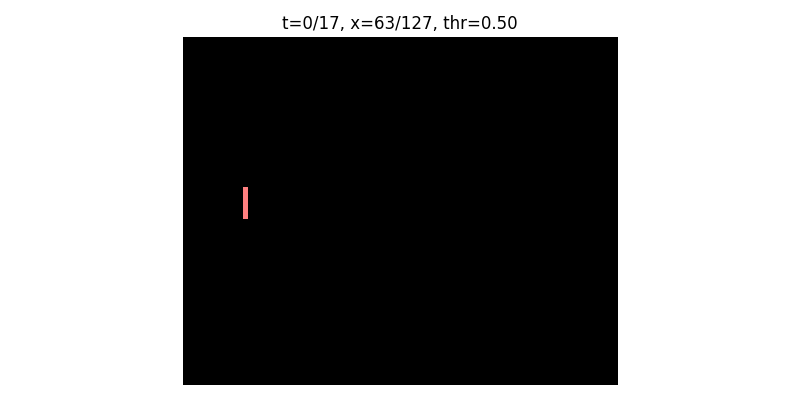

In [22]:
_ = draw_nifti_slices_with_time(imgs, brain_mask=postmask, percentiles=(1,98), slice_along_axis='x')

(32, 40, 32, 18) 0.0 197.10765


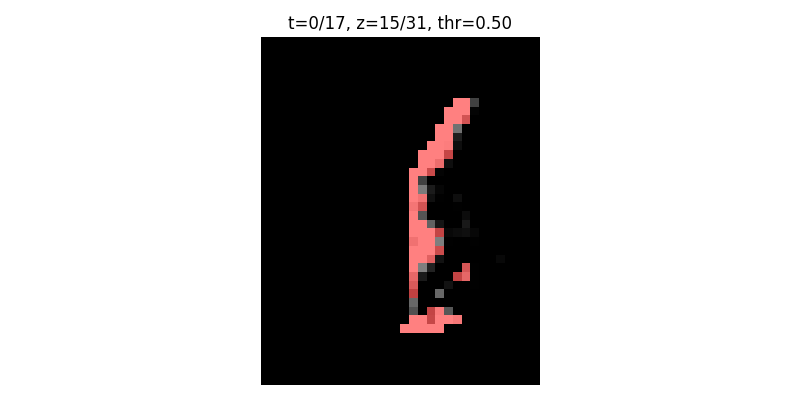

In [23]:

pixdim = pixdim / np.array(zoom_factors)

# zoom and masked (optionally threshold) each image in the 4D array
zoom_factors_4d = (*zoom_factors, 1)

downsampled_mask = zoom(postmask.astype(float), zoom_factors, order=1) > 0.5 # Use linear for masks

down_imgs = zoom(imgs, zoom_factors_4d, order=3)
down_imgs *= downsampled_mask[..., np.newaxis]  # apply mask

down_imgs[down_imgs < 0] = 0

# Print the new shape
print(down_imgs.shape, down_imgs.min(), down_imgs.max())
_ = draw_nifti_slices_with_time(down_imgs)


In [24]:
# prepare x, which is from pixdim per voxel
x = np.arange(0, down_imgs.shape[0]) * pixdim[0]
y = np.arange(0, down_imgs.shape[1]) * pixdim[1]
z = np.arange(0, down_imgs.shape[2]) * pixdim[2]
print(x.shape, y.shape, z.shape, pixdim)

os.makedirs(os.path.dirname(save_path), exist_ok=True)
# Save the downsampled volume (masked + optionally thresholded) as npz,
# ready to be used in PINN training
np.savez_compressed(save_path,
                    data=down_imgs.astype(np.float32),
                    mask=downsampled_mask.astype(np.bool_),
                    pixdim=pixdim.astype(np.float32),
                    x=x.astype(np.float32),
                    y=y.astype(np.float32),
                    z=z.astype(np.float32),
                    t=np.array(timestamp, dtype=np.float32),)

(32,) (40,) (32,) [0.5 0.5 0.5]
